In [1]:
import torch
import math
import numpy as np
from matplotlib import pyplot as plt
import os
import subprocess
import sys
sys.path.append('..')
from Tools import syncer 
from Tools import user
from Tools import helpers

Welcome to JupyROOT 6.24/06


In [2]:
print(sys.version)
os.getcwd()

3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:38:57) [GCC 10.3.0]


'/users/sridhar.bulusu/ML-pytorch/examples'

In [3]:
from PIL import Image
import glob

In [4]:
import ROOT
from Tools import tdrstyle

In [5]:
def copy_file_cern(path: str, directory: str):
    cmd = ["/usr/bin/scp", path, f"{os.environ['CERN_USER']}@lxplus.cern.ch:/eos/user/{os.environ['CERN_USER'][0]}/{os.environ['CERN_USER']}/www/{directory}"]
    print(cmd)
    subprocess.run(cmd, check=True)

#copy_file_cern("png_to_gif.gif","pytorch")

In [6]:
plot_directory='v3'
model='ZH_Nakamura'
nEvents=30000
bias=10**(1.5/400)

In [7]:
learning_rate = 1e-3
device        = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epoch       = 10000
plot_every    = 250

In [48]:
if model == 'ZH_Nakamura':
    import ZH_Nakamura 
    ZH_Nakamura.feature_names = ZH_Nakamura.feature_names[0:6] # restrict features
    features   = ZH_Nakamura.getEvents(nEvents)[:,0:6]
    feature_names  = ZH_Nakamura.feature_names
    plot_options   = ZH_Nakamura.plot_options
    plot_vars      = ZH_Nakamura.feature_names

    mask       = (features[:,feature_names.index('pT')]<900) & (features[:,feature_names.index('sqrt_s_hat')]<1800) 
    features = features[mask]
   
    
    n_features = len(features[0]) 
       
    weights    = ZH_Nakamura.getWeights(features, ZH_Nakamura.make_eft() )
    #weights_scaled = weights.copy()
    
    pT=features[:,feature_names.index('pT')]
   
    bias_factor=bias**pT
    
    for key,value in weights.items():
        value*=bias_factor
        weights[key]=value

    WC = 'cHW'
    train_sel, test_sel = list(map(list,torch.utils.data.random_split(range(len(features)), [len(features)//2,len(features)-len(features)//2] )))

    features_train = torch.from_numpy(features[train_sel]).float().to(device)
    w0_train       = torch.from_numpy(weights[()][train_sel]).float().to(device)
    wp_train       = torch.from_numpy(weights[(WC,)][train_sel]).float().to(device)
    wpp_train      = torch.from_numpy(weights[(WC,WC)][train_sel]).float().to(device)

    features_test = torch.from_numpy(features[test_sel]).float().to(device)
    w0_test       = torch.from_numpy(weights[()][test_sel]).float().to(device)
    wp_test       = torch.from_numpy(weights[(WC,)][test_sel]).float().to(device)
    wpp_test      = torch.from_numpy(weights[(WC,WC)][test_sel]).float().to(device)

Requested 30000 events. Simulated 30000 events and 30000 survive pT_min cut of 0.


In [50]:
def make_NN( hidden_layers  = [128, 64, 32, 16] ):
    model_nn = [torch.nn.BatchNorm1d(n_features), torch.nn.ReLU(), torch.nn.Linear(n_features, hidden_layers[0])]
    for i_layer, layer in enumerate(hidden_layers):

        model_nn.append(torch.nn.Linear(hidden_layers[i_layer], hidden_layers[i_layer+1] if i_layer+1<len(hidden_layers) else 1))
        if i_layer+1<len(hidden_layers):
            model_nn.append( torch.nn.ReLU() )

    return torch.nn.Sequential(*model_nn)

In [51]:
model_t = make_NN() 
model_s = make_NN() 

In [52]:
print ("model_t\n", model_t)
print ("model_s\n", model_s)

model_t
 Sequential(
  (0): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=128, bias=True)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=32, bias=True)
  (6): ReLU()
  (7): Linear(in_features=32, out_features=16, bias=True)
  (8): ReLU()
  (9): Linear(in_features=16, out_features=1, bias=True)
)
model_s
 Sequential(
  (0): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=128, bias=True)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=32, bias=True)
  (6): ReLU()
  (7): Linear(in_features=32, out_features=16, bias=True)
  (8): ReLU()
  (9): Linear(in_features=16, out_features=1, bias=True)
)


In [53]:
def f_loss(w0_input, wp_input, wpp_input, t_output, s_output):
    base_points = [-1.5, -.8, -.4, -.2, .2, .4, .8, 1.5]
    loss = -0.5*w0_input.sum()
    for theta in base_points:
        fhat  = 1./(1. + ( 1. + theta*t_output)**2 + (theta*s_output)**2 )
        loss += ( w0_input*( -0.25 + (1. + wp_input/w0_input*theta +.5*wpp_input/w0_input*theta**2)*fhat**2 + (1-fhat)**2 ) ).sum()
        #FIXME -> weight ratios should be computed only once ... this is a waste
      
    return loss

In [54]:
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(model_t.parameters())+list(model_s.parameters()), lr=learning_rate)

losses = []
losses_test = []
losses_train=[]

In [55]:
tex = ROOT.TLatex()
tex.SetNDC()
tex.SetTextSize(0.04)

In [56]:
# variables for ploting results
model_s.train()
model_t.train()
for epoch in range(n_epoch):
    # Forward pass: compute predicted y by passing x to the model.
    pred_t = model_t(features_train).squeeze()
    pred_s = model_s(features_train).squeeze()

    #print ("t", pred_t.mean(), "s", pred_s.mean())

    # Compute and print loss.
    loss = f_loss(w0_train, wp_train ,wpp_train, pred_t, pred_s)
    losses.append(loss.item())
    #if epoch % 100 == 99:
        #print("epoch", epoch, "loss",  loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if (epoch % plot_every)==0:
        with torch.no_grad():
            pred_t = model_t(features_train).squeeze().cpu().detach().numpy()
            pred_s = model_s(features_train).squeeze().cpu().detach().numpy()
            pred_t_test = model_t(features_test).squeeze().cpu().detach().numpy()
            pred_s_test = model_s(features_test).squeeze().cpu().detach().numpy()
            
            loss_train = f_loss(w0_train, wp_train ,wpp_train, pred_t, pred_s)
            losses_train.append(loss_train.item())
            loss_test = f_loss(w0_test, wp_test ,wpp_test, pred_t_test, pred_s_test)
            losses_test.append(loss_test.item())
            
            print("epoch", epoch, "loss",  loss.item())
            print("epoch", epoch, "test loss",  loss_test.item())
            
            for var in plot_vars:
                binning     = plot_options[var]['binning']
                np_binning  = np.linspace(binning[1], binning[2], 1+binning[0])

                truth_0  = np.histogram(features_train[:,feature_names.index(var)], np_binning, weights=w0_train )
                truth_p  = np.histogram(features_train[:,feature_names.index(var)], np_binning, weights=wp_train )
                truth_pp = np.histogram(features_train[:,feature_names.index(var)], np_binning, weights=wpp_train )

                #pred_0  = np.histogram(features_train[:,feature_names.index(var)], np_binning, weights=w0_train )
                pred_p  = np.histogram(features_train[:,feature_names.index(var)], np_binning, weights=w0_train*2*pred_t )
                pred_pp = np.histogram(features_train[:,feature_names.index(var)], np_binning, weights=w0_train*2*(pred_t*pred_t+pred_s**2) )

                h_yield       = helpers.make_TH1F(truth_0)
                h_truth_p     = helpers.make_TH1F(truth_p)
                h_truth_p     .Divide(h_yield) 
                h_truth_pp    = helpers.make_TH1F(truth_pp)
                h_truth_pp    .Divide(h_yield) 

                h_pred_p      = helpers.make_TH1F(pred_p)
                h_pred_p      .Divide(h_yield) 
                h_pred_pp     = helpers.make_TH1F(pred_pp)
                h_pred_pp     .Divide(h_yield) 

                l = ROOT.TLegend(0.3,0.7,0.9,0.95)
                l.SetNColumns(2)
                l.SetFillStyle(0)
                l.SetShadowColor(ROOT.kWhite)
                l.SetBorderSize(0)

                h_yield      .SetLineColor(ROOT.kGray+2) 
                h_truth_p    .SetLineColor(ROOT.kBlue) 
                h_truth_pp   .SetLineColor(ROOT.kRed) 
                h_pred_p     .SetLineColor(ROOT.kBlue) 
                h_pred_pp    .SetLineColor(ROOT.kRed) 
                h_yield      .SetMarkerColor(ROOT.kGray+2) 
                h_truth_p    .SetMarkerColor(ROOT.kBlue) 
                h_truth_pp   .SetMarkerColor(ROOT.kRed) 
                h_pred_p     .SetMarkerColor(ROOT.kBlue) 
                h_pred_pp    .SetMarkerColor(ROOT.kRed) 
                h_yield      .SetMarkerStyle(0)
                h_truth_p    .SetMarkerStyle(0)
                h_truth_pp   .SetMarkerStyle(0)
                h_pred_p     .SetMarkerStyle(0)
                h_pred_pp    .SetMarkerStyle(0)

                l.AddEntry(h_truth_p   , "1^{st.} der (truth)" ) 
                l.AddEntry(h_truth_pp  , "2^{st.} der (truth)" ) 
                l.AddEntry(h_pred_p    , "1^{st.} der (pred)" ) 
                l.AddEntry(h_pred_pp   , "2^{st.} der (pred)" ) 
                l.AddEntry(h_yield     , "yield" ) 

                h_truth_p    .SetLineStyle(ROOT.kDashed) 
                h_truth_pp   .SetLineStyle(ROOT.kDashed)

                lines = [ 
                        (0.16, 0.965, 'Epoch %5i    Loss %6.4f'%( epoch, loss ))
                        ]

                max_ = max( map( lambda h:h.GetMaximum(), [ h_truth_p, h_truth_pp ] ))

                h_yield.Scale(max_/h_yield.GetMaximum())
                for logY in [True, False]:
                    c1 = ROOT.TCanvas()
                    h_yield   .Draw("hist")
                    h_yield   .GetYaxis().SetRangeUser(0.1 if logY else 0, 10**(1.5)*max_ if logY else 1.5*max_)
                    h_yield   .Draw("hist")
                    h_truth_p .Draw("hsame") 
                    h_truth_pp.Draw("hsame")
                    h_pred_p  .Draw("hsame") 
                    h_pred_pp .Draw("hsame")
                    c1.SetLogy(logY) 
                    l.Draw()

                    drawObjects = [ tex.DrawLatex(*line) for line in lines ]
                    for o in drawObjects:
                        o.Draw()

                    plot_directory_final = os.path.join(model, plot_directory, "log" if logY else "lin")
                    helpers.copyIndexPHP( plot_directory )
                    c1.Print( os.path.join( plot_directory, "epoch_%05i_%s.png"%(epoch, var) ) )
            

epoch 0 loss 1.6216096878051758
epoch 0 test loss 1.5527644157409668
epoch 250 loss 0.7955597043037415
epoch 250 test loss 0.7484189867973328
epoch 500 loss 0.7481946349143982
epoch 500 test loss 0.7070264220237732
epoch 750 loss 0.7272367477416992
epoch 750 test loss 0.6858431100845337
epoch 1000 loss 0.7193883657455444
epoch 1000 test loss 0.6782382726669312
epoch 1250 loss 0.7157649993896484
epoch 1250 test loss 0.674793004989624
epoch 1500 loss 0.7126739621162415
epoch 1500 test loss 0.6721774935722351
epoch 1750 loss 0.7119482755661011
epoch 1750 test loss 0.6715638041496277
epoch 2000 loss 0.7112990617752075
epoch 2000 test loss 0.6708359718322754
epoch 2250 loss 0.7105099558830261
epoch 2250 test loss 0.6699095368385315
epoch 2500 loss 0.7102951407432556
epoch 2500 test loss 0.6698344945907593
epoch 2750 loss 0.7099275588989258
epoch 2750 test loss 0.6695356965065002
epoch 3000 loss 0.7097576856613159
epoch 3000 test loss 0.6695024371147156
epoch 3250 loss 0.7096098065376282
epo

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file v3/epoch_00000_sqrt_s_hat.png has been created
Info in <TCanvas::Print>: png file v3/epoch_00000_sqrt_s_hat.png has been created
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file v3/epoch_00000_pT.png has been created
Info in <TCanvas::Print>: png file v3/epoch_00000_p

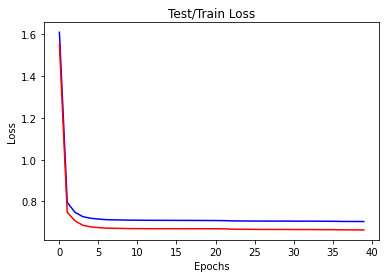

In [57]:
losses_figure = plt.gcf()
plt.plot(losses_train, color='b')
plt.plot(losses_test, color='r')
plt.title('Test/Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
losses_figure.savefig(os.getcwd()+'/loss_train.png')

In [58]:
pTFiles=[]

for file in os.listdir(os.getcwd()+'/v3'):
    # check only text files
    if file.endswith('pT.png'):
        pTFiles.append(file)
        print(file)
frames=[]
for image in pTFiles:
    new_frame = Image.open(os.getcwd()+'/v3/'+image)
    frames.append(new_frame)

frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

epoch_00000_pT.png
epoch_00250_pT.png
epoch_00500_pT.png
epoch_00750_pT.png
epoch_01000_pT.png
epoch_01250_pT.png
epoch_01500_pT.png
epoch_01750_pT.png
epoch_02000_pT.png
epoch_02250_pT.png
epoch_02500_pT.png
epoch_02750_pT.png
epoch_03000_pT.png
epoch_03250_pT.png
epoch_03500_pT.png
epoch_03750_pT.png
epoch_04000_pT.png
epoch_04250_pT.png
epoch_04500_pT.png
epoch_04750_pT.png
epoch_05000_pT.png
epoch_05250_pT.png
epoch_05500_pT.png
epoch_05750_pT.png
epoch_06000_pT.png
epoch_06250_pT.png
epoch_06500_pT.png
epoch_06750_pT.png
epoch_07000_pT.png
epoch_07250_pT.png
epoch_07500_pT.png
epoch_07750_pT.png
epoch_08000_pT.png
epoch_08250_pT.png
epoch_08500_pT.png
epoch_08750_pT.png
epoch_09000_pT.png
epoch_09250_pT.png
epoch_09500_pT.png
epoch_09750_pT.png
